In [2]:
from collections import defaultdict
from pprint import pprint
import re

In [2]:
nscounts = {}
nscounts['defects4j']={}
nscounts['refOracle']={}

szratios = {}
szratios['defects4j'] = defaultdict(list)
szratios['refOracle'] = defaultdict(list)

with open('info_nodesize_v2.37.log','r',encoding='utf8') as f:
  dataset = None
  caseinfo = None
  srcsize = None
  for e in f.readlines():
    e=e.strip()
    if ' - ' in e:
      e = e.rsplit(' - ',1)[1]
      if e.startswith('Started for'):
        caseinfo = e.split('for')[-1].strip()
        dataset = 'refOracle' if caseinfo.startswith('https://github.com') else 'defects4j'
        nscount = defaultdict(dict)
        filename = 0
      elif e.startswith('Finished for '):
        if nscount:
          nscounts[dataset][caseinfo]=nscount
      # elif e.startswith('file name:'):
      #   filename = e.split(':')[-1].strip()
      #   nscount[filename] = {}
      elif e.startswith('Srcs size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['AS'] = sz
        filename+=1
        srcsize = sz
      elif e.startswith('allMappedSrcs size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['MS'] = sz
        szratios[dataset]['MS'].append(sz/srcsize)
      elif e.startswith('unmappedNodes size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['USUD'] = sz
        szratios[dataset]['USUD'].append(sz/srcsize)
      elif e.startswith('curMappedSrcs size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['PS1'] = sz
        szratios[dataset]['PS1'].append(sz/srcsize)
      elif e.startswith('prunedMappedSrcs size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['PS2'] = sz
        szratios[dataset]['PS2'].append(sz/srcsize)
      elif e.startswith('prunedMappedSrcsWithIdentRoot size:'):
        sz = int(e.split(':')[-1].strip())
        nscount[filename]['PS3'] = sz
        szratios[dataset]['PS3'].append(sz/srcsize)


In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# plt.rc('font',family='Times New Roman')
plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix

<IPython.core.display.Javascript object>


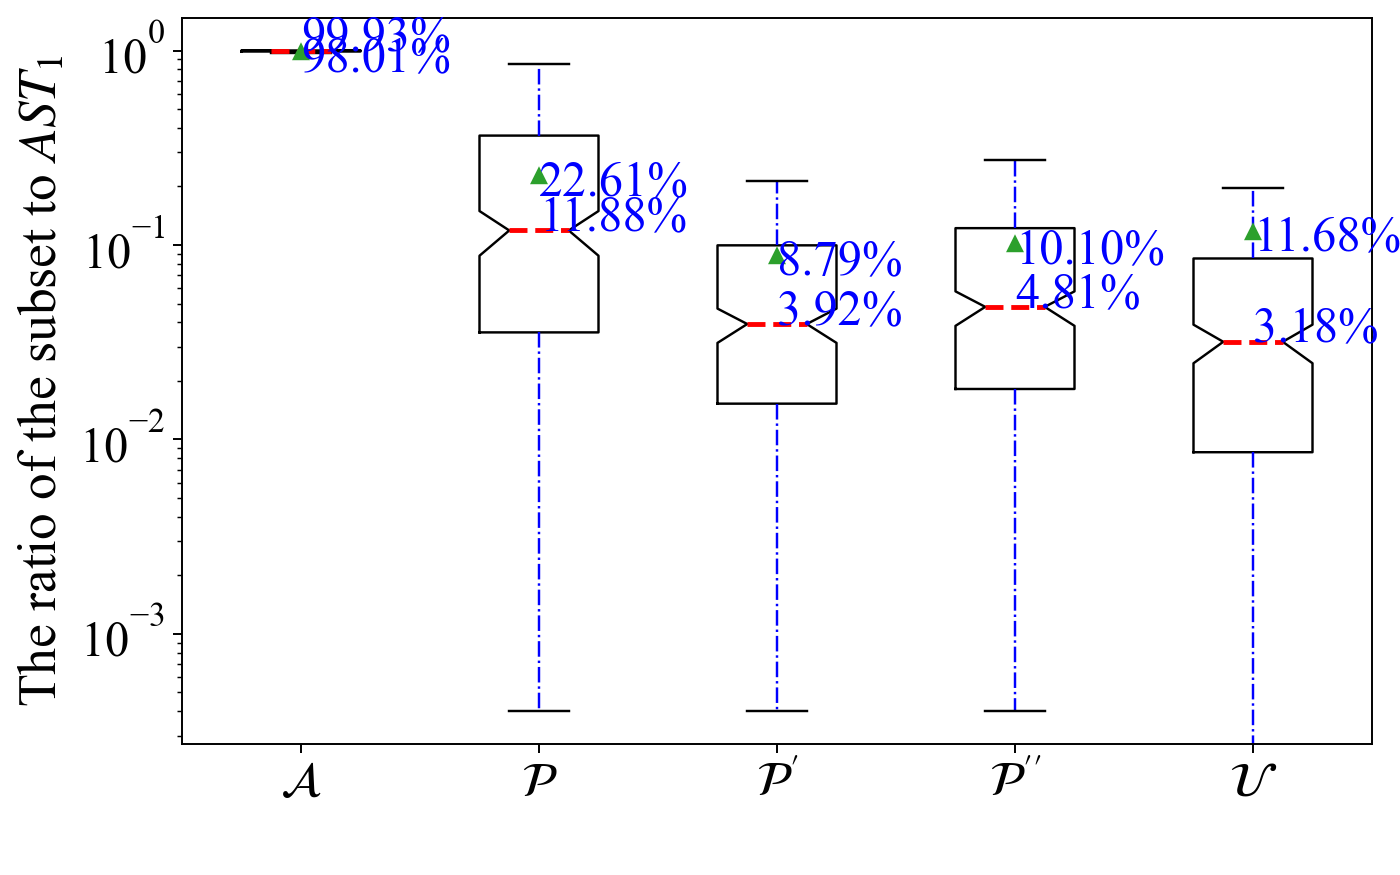

In [40]:
# fig, axs = plt.subplots(2, 1, figsize=(6, 8))

def plot_data(name):
    plt.subplots(figsize=(8,5))
    plt.subplots_adjust(left=0.13,right=0.98,top=0.98,bottom=0.15)
    ax = plt.subplot()
    data = [szratios[name][e] for e in ['MS','PS1','PS2','PS3','USUD']]
    ax.boxplot(data,
               notch=True,showmeans=True,showfliers=False,
               medianprops={'lw':2,'ls':'--','color':'red'},
               whiskerprops={'ls':'-.','color':'blue'})
#     ax.set_xlim(0.6,5.6)
#     ax.set_xticklabels(['Mapped $AST_1$\n nodes $\mathcal{A}$','Pruned $AST_1$\nnodes $\mathcal{P}$',
#                         'Pruned $AST_1$\nnodes $\mathcal{P}\'$','Pruned $AST_1$\nnodes $\mathcal{P}\'\'$',
#                         'Unmapped $AST_1$\nand $AST_2$ nodes $\mathcal{U}$'],fontsize=18)
    
    ax.set_xticklabels(['$\mathcal{A}$','$\mathcal{P}$',
                        '$\mathcal{P}\'$','$\mathcal{P}\'\'$',
                        '$\mathcal{U}$'],fontsize=20)
    
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(labelsize=20)
    
    ax.set_ylabel('The ratio of the subset to $AST_1$',fontsize=22)
#     ax.set_xlabel(' Node subset used in DiffFix and MovOpt',fontsize=19)

    for i in range(len(data)):
        mean = np.mean(data[i])
        median = np.median(data[i])
        ax.text(i+1,mean*0.8,f'{mean:.2%}',fontsize=20,color='blue')
        ax.text(i+1,median,f'{median:.2%}',fontsize=20,color='blue')
        
    plt.savefig(f'nodesize_{name}.svg')

# plot_data('defects4j')
plot_data('refOracle')

In [4]:
def calcES(eslogfile):
  toolescount = {}
  toolescount['defects4j']={}
  toolescount['refOracle']={}

  totalescount = {}
  totalescount['defects4j']={}
  totalescount['refOracle']={}

  with open(eslogfile,'r',encoding='utf8') as f:
    dataset = None
    caseinfo = None
    for e in f.readlines():
      e=e.strip()
      if ' - ' in e:
        e = e.rsplit(' - ',1)[1]
        if e.startswith('Started for'):
          caseinfo = e.split('for')[-1].strip()
          dataset = 'refOracle' if caseinfo.startswith('https://github.com') else 'defects4j'
          escount = {}
          escount['total'] = {}
          # filename=0
        elif e.startswith('Finished for '):
          if escount:
            toolescount[dataset][caseinfo]=escount
            for toolname in escount['total']:
              if toolname not in totalescount[dataset]:
                totalescount[dataset][toolname] = defaultdict(int)
              totalescount[dataset][toolname]['essize']+=escount['total'][toolname]['essize']
              totalescount[dataset][toolname]['addcnt']+=escount['total'][toolname]['addcnt']
              totalescount[dataset][toolname]['delcnt']+=escount['total'][toolname]['delcnt']
              totalescount[dataset][toolname]['updcnt']+=escount['total'][toolname]['updcnt']
              totalescount[dataset][toolname]['movcnt']+=escount['total'][toolname]['movcnt']
              totalescount[dataset][toolname]['mulmovcnt']+=escount['total'][toolname]['mulmovcnt']
              totalescount[dataset][toolname]['movoutcnt']+=escount['total'][toolname]['movoutcnt']
              totalescount[dataset][toolname]['movincnt']+=escount['total'][toolname]['movincnt']
        elif e.startswith('file name:'):
          filename = e.split(':')[-1].strip()
          escount[filename] = defaultdict(dict)
        elif e.startswith('tool name:') and 'es size' in e:
          pat='tool name: (.*?), es size: (.*?), inscnt: (.*?), delcnt: (.*?), repcnt: (.*?), movcnt: (.*?), mulmovcnt: (.*?), movoutcnt: (.*?), movincnt: (.*?)$'
          mat=re.search(pat,e).groups()
          toolname = mat[0]
          # if toolname == 'RMD_Mod':
          #   filename+=1
          # if filename not in escount:
          #   escount[filename] = defaultdict(dict)
          essize=int(mat[1])
          inscnt=int(mat[2])
          delcnt=int(mat[3])
          repcnt=int(mat[4])
          movcnt=int(mat[5])
          mulmovcnt=int(mat[6])
          movoutcnt=int(mat[7])
          movincnt=int(mat[8])
          escount[filename][toolname]['essize']=essize
          escount[filename][toolname]['addcnt']=inscnt
          escount[filename][toolname]['delcnt']=delcnt
          escount[filename][toolname]['updcnt']=repcnt
          escount[filename][toolname]['movcnt']=movcnt
          escount[filename][toolname]['mulmovcnt']=mulmovcnt
          escount[filename][toolname]['movoutcnt']=movoutcnt
          escount[filename][toolname]['movincnt']=movincnt
          if toolname not in escount['total']:
            escount['total'][toolname] = defaultdict(int)
          escount['total'][toolname]['essize']+=essize
          escount['total'][toolname]['addcnt']+=inscnt
          escount['total'][toolname]['delcnt']+=delcnt
          escount['total'][toolname]['updcnt']+=repcnt
          escount['total'][toolname]['movcnt']+=movcnt
          escount['total'][toolname]['mulmovcnt']+=mulmovcnt
          escount['total'][toolname]['movoutcnt']+=movoutcnt
          escount['total'][toolname]['movincnt']+=movincnt

  return toolescount,totalescount

toolescountGOD,totalescountGOD=calcES('info_GOD.log')
toolescount0,totalescount0=calcES('info_Original.log')
toolescount1,totalescount1=calcES('info_v2.37.log')
toolescount2,totalescount2=calcES('info_MoveOpt.log')

In [21]:
def compareActionDelta2():
  dfdeltas = {}
  mtdeltas = {}
  for dataset in ['defects4j','refOracle']:
    print('----- '+dataset+' -----')
    dfdelta = defaultdict(list)
    mtdelta = defaultdict(list)
    for toolname in ['RMD', 'IAM', 'DAT', 'GTS', 'GTG']:
      for caseinfo in toolescount0[dataset]:
        es1cnt=toolescount1[dataset][caseinfo]['total'][toolname+'_Mod']['essize']-toolescount0[dataset][caseinfo]['total'][toolname]['essize']
        es2cnt=toolescount2[dataset][caseinfo]['total'][toolname+'_MT']['essize']-toolescount0[dataset][caseinfo]['total'][toolname]['essize']
        if es1cnt:
            dfdelta[toolname].append(es1cnt)
        if es2cnt:
            mtdelta[toolname].append(es2cnt)
    dfdeltas[dataset]=dfdelta
    mtdeltas[dataset]=mtdelta
  return dfdeltas,mtdeltas

dfdeltas,mtdeltas = compareActionDelta2()

----- defects4j -----
----- refOracle -----


<IPython.core.display.Javascript object>


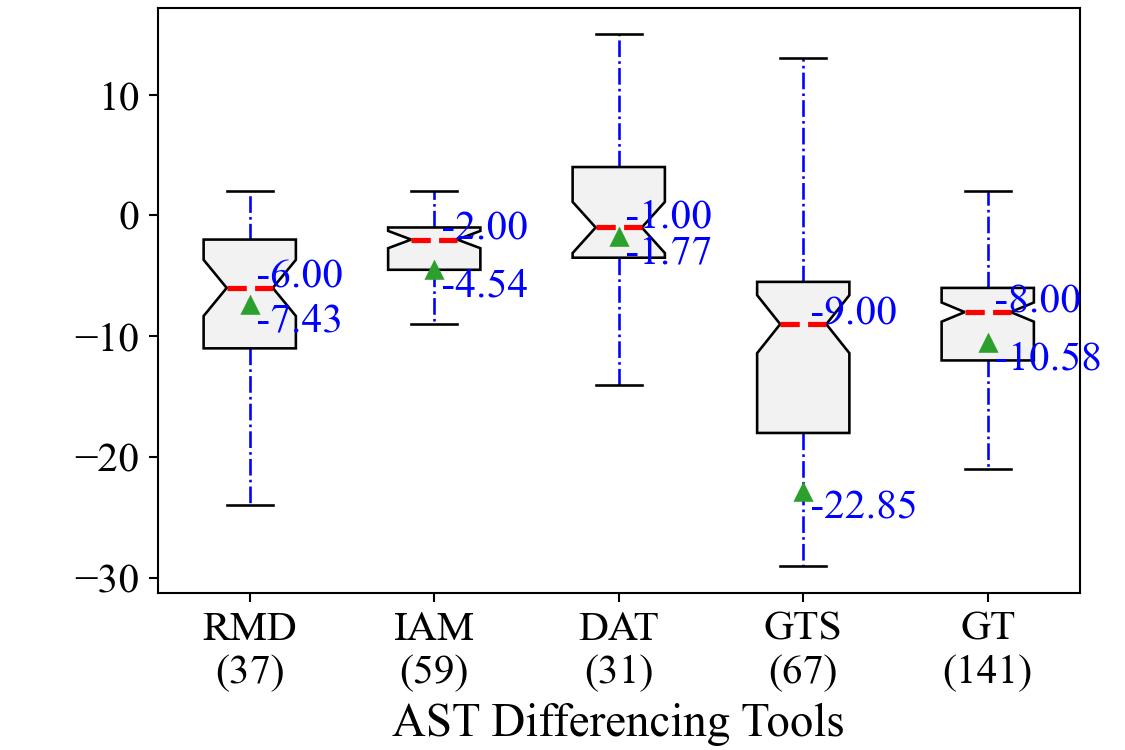

RMD 37
IAM 59
DAT 31
GTS 67
GTG 141


In [71]:
def plot_data2(name):
    plt.subplots(figsize=(6,4))
    plt.subplots_adjust(left=0.14,right=0.96,top=0.99,bottom=0.21)
    ax = plt.subplot()
    data=[]
    for e in ['RMD', 'IAM', 'DAT', 'GTS', 'GTG']:
        data.append(dfdeltas[name][e])
        print(e,len(dfdeltas[name][e]))
#         data.append(mtdeltas[name][e])
    ax.boxplot(data,
               notch=True,showmeans=True,showfliers=False,
               patch_artist=True,
               boxprops={'facecolor':'#F2F2F2'},
               medianprops={'lw':2,'ls':'--','color':'red'},
               whiskerprops={'ls':'-.','color':'blue'})
#     ax.set_xlim(0.6,5.6)
#     ax.set_xticklabels(['RM-ASTDiff\nw/ DiffFix','RM-ASTDiff\nw/ MovOpt',
#                         'iASTMapper\nw/ DiffFix','iASTMapper\nw/ MovOpt', 
#                         'DiffAutoTuning\nw/ DiffFix','DiffAutoTuning\nw/ MovOpt',
#                         'GumTree-simple\nw/ DiffFix','GumTree-simple\nw/ MovOpt',
#                         'GumTree\nw/ DiffFix','GumTree\nw/ MovOpt'],rotation=30,fontsize=12)
#     ax.set_xticklabels(['RM-ASTDiff','iASTMapper ','DiffAutoTuning','GumTree-simple','GumTree'],fontsize=12)
    ax.set_xticklabels([f'RMD\n({len(dfdeltas[name]["RMD"])})',f'IAM\n({len(dfdeltas[name]["IAM"])})',f'DAT\n({len(dfdeltas[name]["DAT"])})',
                        f'GTS\n({len(dfdeltas[name]["GTS"])})',f'GT\n({len(dfdeltas[name]["GTG"])})'],fontsize=16)
    plt.yticks(fontsize=16)
#     ax.set_yscale('log')
#     ax.set_ylabel('ΔES after applying fixing algo.',fontsize=14)
#     ax.set_xlabel('Configuration of mapping algo. with fixing algo.',fontsize=14)

#     ax.set_ylabel('ΔES after applying DIFFFIX',fontsize=18)
    ax.set_xlabel('AST Differencing Tools',fontsize=18)
    
    for i in range(len(data)):
        mean = np.mean(data[i])
        median = np.median(data[i])
        ax.text(i+0.98,mean-2.2,f' {mean:.2f}',fontsize=16,color='blue')
        ax.text(i+0.98,median,f' {median:.2f}',fontsize=16,color='blue')
        
#     for i in range(1,len(data),1):
#         ax.axvline(i+0.5,ls='--',lw='1',c='grey')
        
    plt.savefig(f'essize_{name}.svg')

# plot_data2('defects4j')
plot_data2('refOracle')

In [50]:
import json

with open('avg_fixing_time.json','r',encoding='utf8') as f:
    avg_fixing_time = json.load(f)

<IPython.core.display.Javascript object>


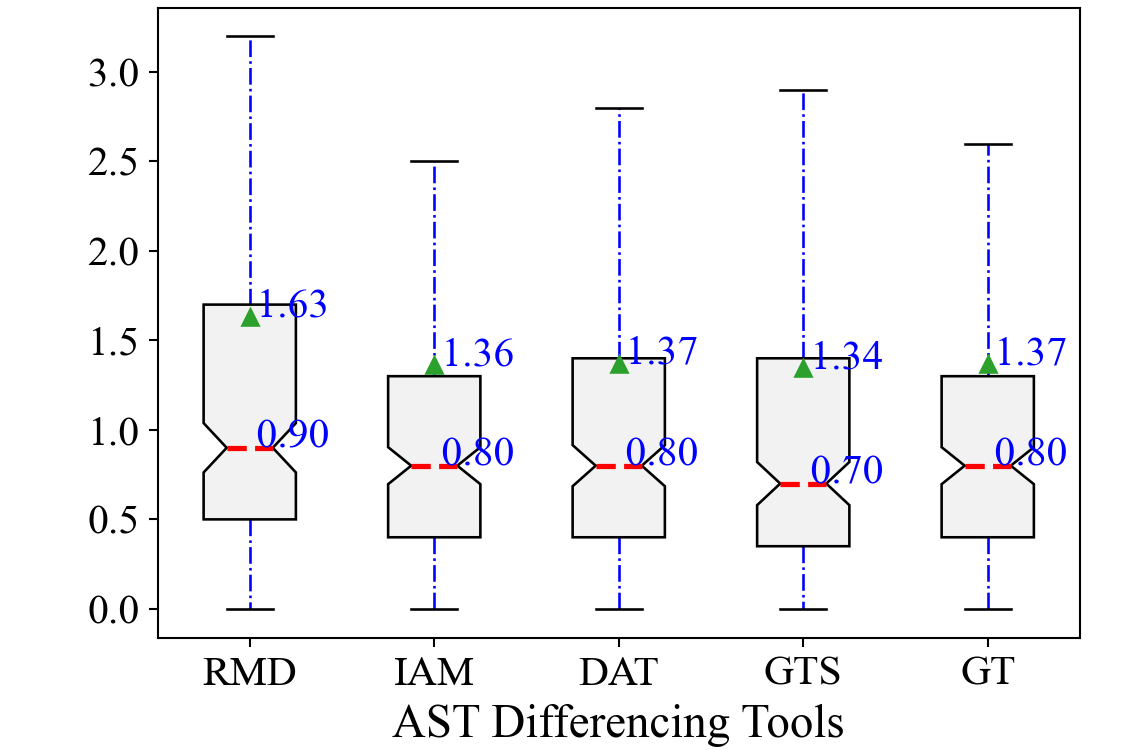

In [73]:
def plot_data3(name):
    plt.subplots(figsize=(6,4))
    plt.subplots_adjust(left=0.14,right=0.96,top=0.99,bottom=0.15)
    ax = plt.subplot()
    data=[]
    for e in ['RMD', 'IAM', 'DAT', 'GTS', 'GTG']:
        data.append(avg_fixing_time[name][e])
#         print(e,len(avg_fixing_time[name][e]))
#         data.append(mtdeltas[name][e])
    ax.boxplot(data,
               notch=True,showmeans=True,showfliers=False,
               patch_artist=True,
               boxprops={'facecolor':'#F2F2F2'},
               medianprops={'lw':2,'ls':'--','color':'red'},
               whiskerprops={'ls':'-.','color':'blue'})
#     ax.set_xlim(0.6,5.6)
#     ax.set_xticklabels(['RM-ASTDiff\nw/ DiffFix','RM-ASTDiff\nw/ MovOpt',
#                         'iASTMapper\nw/ DiffFix','iASTMapper\nw/ MovOpt', 
#                         'DiffAutoTuning\nw/ DiffFix','DiffAutoTuning\nw/ MovOpt',
#                         'GumTree-simple\nw/ DiffFix','GumTree-simple\nw/ MovOpt',
#                         'GumTree\nw/ DiffFix','GumTree\nw/ MovOpt'],rotation=30,fontsize=12)
#     ax.set_xticklabels(['RM-ASTDiff','iASTMapper ','DiffAutoTuning','GumTree-simple','GumTree'],fontsize=12)
    ax.set_xticklabels(['RMD','IAM','DAT','GTS','GT'],fontsize=16)
    plt.yticks(fontsize=16)
#     ax.set_yscale('log')
#     ax.set_ylabel('ΔES after applying fixing algo.',fontsize=14)
#     ax.set_xlabel('Configuration of mapping algo. with fixing algo.',fontsize=14)

#     ax.set_ylabel('Time Spent of Diff Fixing (ms)',fontsize=18)
    ax.set_xlabel('AST Differencing Tools',fontsize=18)
    
    for i in range(len(data)):
        mean = np.mean(data[i])
        median = np.median(data[i])
        ax.text(i+0.98,mean,f' {mean:.2f}',fontsize=16,color='blue')
        ax.text(i+0.98,median,f' {median:.2f}',fontsize=16,color='blue')
        
#     for i in range(1,len(data),1):
#         ax.axvline(i+0.5,ls='--',lw='1',c='grey')
        
    plt.savefig(f'fixingtime_{name}.svg')

# plot_data3('defects4j')
plot_data3('refOracle')